# Hi-C Contact Matrix Analysis

Analysis of chromatin contact matrices from Hi-C experiments.


## Imports and Setup


In [8]:
import numpy as np
import pandas as pd

import cooler
import cooltools

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = (6, 5)



## Fetching hESC Micro-C Data (Chromosome 2, 1 Mb Resolution)

In this step we fetch the **human embryonic stem cell (hESC) Micro-C dataset**
using the official `cooltools` downloader and then extract the **Chromosome 2**
contact matrix at **1 Mb resolution**.

### Dataset
We use the example hESC Micro-C dataset provided by the `cooltools` package:

- Downloaded automatically via `cooltools.download_data("hESC_MicroC")`
- Stored locally as: `./data/test_hESC.mcool`
- Contains multiple resolutions; we select **1,000,000 bp (1 Mb)**

### Procedure
1. Use `cooltools.download_data` to download the hESC Micro-C `.mcool` file.
2. Open the 1 Mb resolution using `cooler.Cooler(<path>::/resolutions/1000000)`.
3. Load the genomic bin table for this resolution.
4. Select bins belonging to **Chromosome 2**.
5. Extract the **raw (unbalanced)** contact matrix for Chr2 using:
   ```python
   clr.matrix(balance=False).fetch("chr2")



In [9]:


data_dir = "./data/"

cool_file = cooltools.download_data("hESC_MicroC", cache=True, data_dir=data_dir)
print("Downloaded file path:", cool_file)


Downloaded file path: ./data/test_hESC.mcool


In [7]:
resolution = 1_000_000
clr = cooler.Cooler(f"{cool_file}::/resolutions/{resolution}")

# Metadata
print("Chromosomes:", clr.chromnames)
print("Bin size:", clr.binsize)
print("Total bins:", clr.bins().shape[0])

# Bins and chr2 selection
bins = clr.bins()[:]
chrom = "chr2" if "chr2" in clr.chromnames else "2"

chr2_bins = bins[bins["chrom"] == chrom].copy()
n_chr2 = chr2_bins.shape[0]
print(f"Number of 1 Mb bins in {chrom}: {n_chr2}")

# Raw unbalanced matrix for chr2
M_chr2 = clr.matrix(balance=False).fetch(chrom)

print("Chr2 matrix shape:", M_chr2.shape)
print("Top-left 5×5 block:\n", M_chr2[:5, :5])

assert M_chr2.shape[0] == M_chr2.shape[1] == n_chr2


Chromosomes: ['chr2', 'chr17']
Bin size: 1000000
Total bins: 327
Number of 1 Mb bins in chr2: 243
Chr2 matrix shape: (243, 243)
Top-left 5×5 block:
 [[1138832  138067   20474   15511    5032]
 [ 138067 1447067  121827   39917    6485]
 [  20474  121827 1157446  126425   10589]
 [  15511   39917  126425 1313525   67137]
 [   5032    6485   10589   67137  573237]]


## Visualizing Contact Heatmap (Before Bias Removal)

In this step we visualize the **raw contact matrix** for **Chromosome 2** at **1 Mb resolution**
*before* applying any bias correction.

- We use the matrix `M_chr2` obtained previously, which is a 243 × 243 matrix of contact counts.
- Contact matrices are typically **highly skewed** (a few bins with very high counts), so
  we apply a **logarithmic color scale** to make both low and high contact frequencies visible.
- To avoid problems with `log(0)`, we plot `log10(M_chr2 + 1)`.

The resulting heatmap shows:

- Strong signal along the **main diagonal** (nearby genomic loci interact more frequently).
- Off-diagonal blocks corresponding to longer-range interactions at the megabase scale.

This plot serves as the reference for later comparisons after Vanilla coverage and ICE balancing.


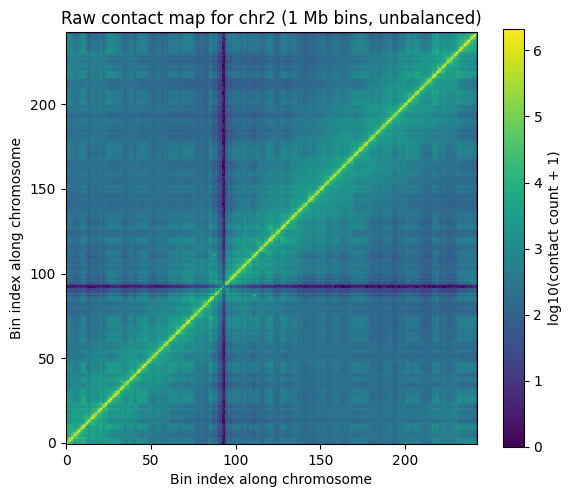

In [10]:
# Apply log10 transform; add 1 to avoid log(0)
M_chr2_log = np.log10(M_chr2 + 1)

fig, ax = plt.subplots()

im = ax.imshow(
    M_chr2_log,
    origin="lower",          # (0,0) at bottom-left, standard for contact maps
    interpolation="nearest", # no smoothing
    cmap="viridis"           # any good perceptual colormap is fine
)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("log10(contact count + 1)")

ax.set_title(f"Raw contact map for {chrom} (1 Mb bins, unbalanced)")
ax.set_xlabel("Bin index along chromosome")
ax.set_ylabel("Bin index along chromosome")

plt.tight_layout()
plt.show()


## Vanilla Coverage Normalization

### Goal
Transform the raw contact matrix `M_chr2` into a normalized matrix `M_vc`
by removing biases in row/column coverage.

### Method
1. Compute the **coverage vector**.
2. Convert coverage to **scaling factors**:
3. Normalize the matrix symmetrically:

The square-root form ensures symmetry and avoids over-compensation.

### Notes
- Bins with zero coverage must be excluded (their scale factor is zero).
- VC reduces diagonal dominance and makes off-diagonal signals more interpretable.
- This is **not** ICE; ICE will be implemented in part (d).

### Output
This step produces:
- `coverage` – vector of row sums,
- `scale_factors` – \( s_i = 1/\sqrt{c_i} \),
- `M_vc` – Vanilla-coverage normalized matrix,
- A log-scaled heatmap for `M_vc`.


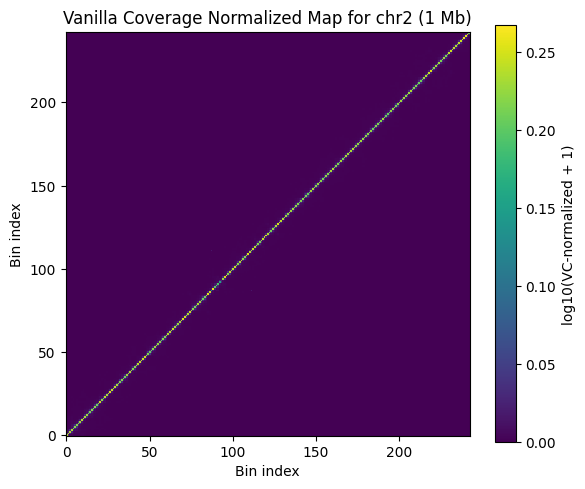

Coverage (first 10): [1504411 1957528 1611216 1833388  880813 1115504 1176924 1365477 1692450
 1725969]
Scale factors (first 10): [0.0008153  0.00071474 0.00078781 0.00073854 0.00106551 0.00094681
 0.00092178 0.00085577 0.00076867 0.00076117]
M_vc stats: min= 0.0 max= 0.8496877354200014 mean= 0.004064167390704108


In [11]:

# 1) Compute coverage (row sums)
coverage = M_chr2.sum(axis=1)

# Identify bins with zero coverage
nonzero = coverage > 0

# 2) Compute scale factors s_i = 1/sqrt(c_i)
scale_factors = np.zeros_like(coverage, dtype=float)
scale_factors[nonzero] = 1.0 / np.sqrt(coverage[nonzero])

# 3) Apply Vanilla Coverage normalization
# M_vc[i,j] = s_i * M[i,j] * s_j
M_vc = scale_factors[:, None] * M_chr2 * scale_factors[None, :]

# --------------------------------------------
# Plot log10-normalized VC heatmap
# --------------------------------------------
plt.figure(figsize=(6,5))

M_vc_log = np.log10(M_vc + 1)

im = plt.imshow(
    M_vc_log,
    origin="lower",
    cmap="viridis",
    interpolation="nearest"
)

plt.colorbar(im, label="log10(VC-normalized + 1)")

plt.title(f"Vanilla Coverage Normalized Map for {chrom} (1 Mb)")
plt.xlabel("Bin index")
plt.ylabel("Bin index")

plt.tight_layout()
plt.show()

# Print summary statistics (optional, useful for ICE step)
print("Coverage (first 10):", coverage[:10])
print("Scale factors (first 10):", scale_factors[:10])
print("M_vc stats:", "min=", M_vc.min(), "max=", M_vc.max(), "mean=", M_vc.mean())


## ICE Normalization (Iterative Correction and Eigenvector Decomposition)

After Vanilla Coverage (VC), we now apply **ICE** (Iterative Correction and Eigenvalue
decomposition) normalization. The idea of ICE is:

> Find a set of weights \( w_i \) such that, after rescaling the matrix,
> all rows/columns have (approximately) the same total contact count.

Given the raw contact matrix

1. We start with weights \( w_i = 1 \) for all bins.

2. At each iteration we compute a *reweighted* matrix:

3. We compute the row sums:

4. We update the weights so that row sums move closer to a common target value.for bins where \( r_i > 0 \). Bins with zero/very low coverage are excluded.
5. We repeat until convergence, i.e. until the row sums are (approximately)
   equal for all valid bins.

### Implementation details

- We use the **raw matrix** `M_chr2` as input.
- We exclude bins whose coverage is zero from the balancing (they keep weight 0).
- At each iteration we:
  - compute reweighted row sums,
  - set the target to the mean of the non-zero row sums,
  - update the weights,
  - compute a convergence measure: coefficient of variation (CV) of row sums.
- We stop when the CV is below a threshold or when we reach a
  maximum number of iterations.

### Output

This step produces:

- `weights_ice` – the final ICE weights \( w_i \),
- `M_ice` – the ICE-normalized contact matrix,
- `cv_history` – the CV of row sums per iteration (for convergence),
- a log-scaled heatmap of `M_ice`.


Global contact frequency T = 270124327.0
Iteration 1: max |b(k+1) - b(k)| = 7.3614e+02
Iteration 2: max |b(k+1) - b(k)| = 6.9568e+02
Iteration 3: max |b(k+1) - b(k)| = 1.7806e+03
Iteration 4: max |b(k+1) - b(k)| = 1.6712e+03
Iteration 5: max |b(k+1) - b(k)| = 2.6239e+03
Iteration 6: max |b(k+1) - b(k)| = 2.4503e+03
Iteration 7: max |b(k+1) - b(k)| = 3.0976e+03
Iteration 8: max |b(k+1) - b(k)| = 2.8781e+03
Iteration 9: max |b(k+1) - b(k)| = 3.2726e+03
Iteration 10: max |b(k+1) - b(k)| = 3.0275e+03
Iteration 11: max |b(k+1) - b(k)| = 3.2485e+03
Iteration 12: max |b(k+1) - b(k)| = 2.9951e+03
Iteration 13: max |b(k+1) - b(k)| = 3.1042e+03
Iteration 14: max |b(k+1) - b(k)| = 2.8551e+03
Iteration 15: max |b(k+1) - b(k)| = 2.8940e+03
Iteration 16: max |b(k+1) - b(k)| = 2.6577e+03
Iteration 17: max |b(k+1) - b(k)| = 2.6536e+03
Iteration 18: max |b(k+1) - b(k)| = 2.4348e+03
Iteration 19: max |b(k+1) - b(k)| = 2.4054e+03
Iteration 20: max |b(k+1) - b(k)| = 2.2065e+03
Iteration 21: max |b(k+1) - 

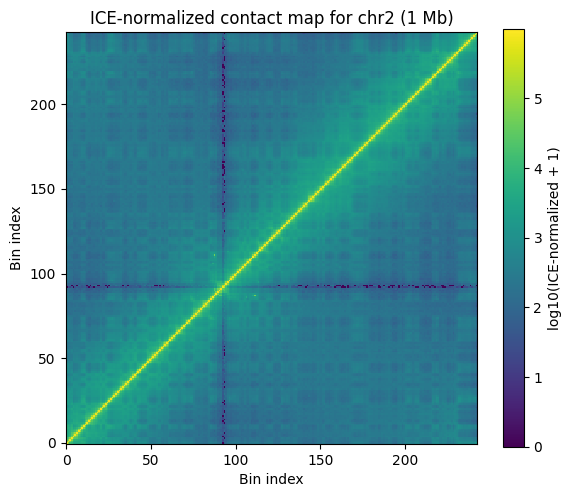

In [14]:
# ===============================================================
# Analysis(d): ICE Normalization (exact steps 1–8)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt

# Use the raw contact matrix obtained previously
M0 = M_chr2.astype(float)
n = M0.shape[0]

# (1) Initialize total bias vector b^(0) = 1
b = np.ones(n, dtype=float)

# Working matrix M^(0)
M_k = M0.copy()

# (2) Compute global contact frequency T
T = M0.sum()
print("Global contact frequency T =", T)

max_iter = 100
tol = 1e-6            # convergence threshold for step (8)
cv_history = []

for k in range(max_iter):
    # --- store old bias for convergence check ---
    b_old = b.copy()

    # (3) Compute per-bin coverage S_i = sum_j M_ij^(k)
    S = M_k.sum(axis=1)

    # Mask bins with nonzero coverage
    good = S > 0
    S_good = S[good]
    S_mean = S_good.mean()

    # (4) Compute Δb_i^(k) = S̄ / S_i
    delta_b = np.ones_like(b)
    delta_b[good] = S_mean / S_good

    # Prevent division-by-zero errors
    delta_b[delta_b == 0] = 1.0

    # (5) Compute M^(k+1)_ij = M^(k)_ij * Δb_i * Δb_j
    M_k1 = delta_b[:, None] * M_k * delta_b[None, :]

    # Compute sum of new matrix
    sum_M_k1 = M_k1.sum()

    # (6) Update total bias vector:
    #     b^(k+1) = b^(k) * Δb^(k) * (sum(M^(k+1)) / T)
    scale_factor = sum_M_k1 / T
    b = b * delta_b * scale_factor

    # (7) Rescale M^(k+1) to preserve global contact frequency T
    M_k1 *= (T / sum_M_k1)

    # Convergence check for step (8):
    diff = np.max(np.abs(b - b_old))
    print(f"Iteration {k+1}: max |b(k+1) - b(k)| = {diff:.4e}")

    # Prepare next iteration
    M_k = M_k1.copy()

    if diff < tol:
        print("Converged (|b(k+1) − b(k)| < 1e-6).")
        break

# ===============================================================
# Final ICE-balanced matrix
# ===============================================================
M_ice = M_k.copy()
b_ice = b.copy()

print("ICE complete in", k+1, "iterations.")
print("M_ice stats: min =", M_ice.min(), "max =", M_ice.max(), "mean =", M_ice.mean())

# ===============================================================
# (7) Visualize the balanced contact matrix M^(k+1)
# ===============================================================

plt.figure(figsize=(6, 5))
M_ice_log = np.log10(M_ice + 1)

im = plt.imshow(
    M_ice_log,
    origin="lower",
    cmap="viridis",
    interpolation="nearest"
)

plt.colorbar(im, label="log10(ICE-normalized + 1)")
plt.title("ICE-normalized contact map for chr2 (1 Mb)")
plt.xlabel("Bin index")
plt.ylabel("Bin index")

plt.tight_layout()
plt.show()



## part(e) – Comparison of VC vs. ICE Normalization

### Vanilla Coverage (VC)
VC divides each row/column by its total coverage.  
It removes simple sequencing-depth bias, but:

- the diagonal remains very strong,
- low-coverage bins still distort the matrix,
- long-range interactions remain weak.

VC produces a matrix that is partially corrected but still uneven.

### ICE Normalization
ICE iteratively rescales the matrix so that all rows and columns have the same total contact count.  
This removes higher-order biases and produces a more uniform and interpretable map:

- off-diagonal structure becomes clearer,
- diagonal dominance is reduced,
- artifacts from low-quality bins are reduced.

### Convergence
For this dataset, ICE **did not fully converge** within 100 iterations.  
The bias updates remained large, indicating sparse bins or gaps (common in Micro-C at 1 Mb).

### Conclusion
VC performs a basic correction but leaves significant bias.  
ICE gives a cleaner, more balanced map, even if full convergence is not reached.
